In [1]:
import os
from torch.utils.data import Dataset
import torch
from torch import optim
from torch import nn as nn
import numpy as np
from matplotlib import pyplot as plt
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import torchvision.transforms as T
import pandas as pd
import glob
from PIL import Image
from sklearn.neighbors import NearestNeighbors
from typing import Callable, Sequence
from utility import img_transform, EmbeddingHead, ClassifierHead
from datetime import date
from sklearn.manifold import TSNE

In [2]:
DATA_PATH = "data/pblock-32965-idx_280x175"
NUM_TRAIN = 6593 # 20%
NUM_TEST = 26372 # 80%
NUM_TOTAL = 35912

In [3]:
df = pd.read_csv(os.path.join(DATA_PATH, "metadata.csv"))
df.head()

pallet_id                                               path  \
0  1001000000000002948  /home/nils/Documents/ude/pallet/data/pblock-32...   
1  1001000000000002948  /home/nils/Documents/ude/pallet/data/pblock-32...   
2  1001000000000002948  /home/nils/Documents/ude/pallet/data/pblock-32...   
3  1001000000000002948  /home/nils/Documents/ude/pallet/data/pblock-32...   
4  1001000000000002949  /home/nils/Documents/ude/pallet/data/pblock-32...   

   camera  frame  target  frame_rel  
0       1   1009       0          0  
1       1   1012       0          1  
2       2   1007       0          0  
3       2   1010       0          1  
4       1   1234       1          0

In [4]:
class PalletDataset():
    def __init__(self, data, target, transform=None, target_transform=None):
        self.data = data
        self.target = target
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        img = Image.open(self.data[idx]).convert('RGB')
        label = self.target[idx]
        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            label = self.target_transform(label)
        return img, label

In [5]:
dataset = PalletDataset(df["path"].values, df["target"].values, transform=lambda x: img_transform(x, is_eval=True), target_transform=lambda x: torch.tensor(x, dtype=torch.long))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False, num_workers=8)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [8]:
net = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=False)
#net.fc = ClassifierHead(net.fc.in_features, NUM_TRAIN)
net.fc = EmbeddingHead()
net.load_state_dict(torch.load("model/model_triplet_256x128_2022-09-10.pth"))
#net.fc = EmbeddingHead()

Using cache found in /home/nils/.cache/torch/hub/pytorch_vision_v0.10.0


In [9]:
embeddings = np.zeros((len(dataset), 2048))
net.eval()
net.to(device)
print(embeddings.shape)

count = 0
with torch.no_grad():
    for i, data in enumerate(dataloader, 0):
        imgs, labels = data
        emb = net(imgs.to(device))
        embeddings[count:count+len(imgs)] = emb.detach().cpu()
        count += len(imgs)

(131860, 2048)


## Embedding space vis

In [9]:
embeddings_2d = TSNE(n_components=2, init="random").fit_transform(embeddings[df.iloc[:2000].index])

([], [])

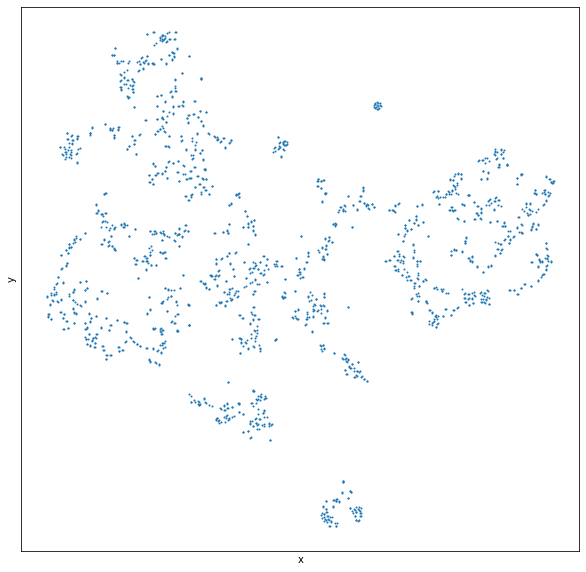

In [10]:
plt.figure(figsize=(10,10))
plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1], s=1)
#plt.title("t-SNE for 2000 images of 500 pallet blocks (contrastive loss)")
plt.xlabel("x")
plt.ylabel("y")
#plt.xlim([-80,-20])
#plt.ylim([-40, 20])
plt.xticks([])
plt.yticks([])
#plt.savefig("img/triplet_emb_vis/tsne.pdf")
#plt.savefig("img/emb_vis/contrastive.pdf")

## Re-Id

In [10]:
query_selector = (df["target"] >= NUM_TRAIN) & (df["target"] < NUM_TRAIN + 5000) & (df["camera"] == 1)
df_query = df.loc[query_selector]

gallery_selector = (df["target"] >= NUM_TRAIN) & (df["camera"] == 2)
df_gallery = df.loc[gallery_selector]

print(df_query.shape)
print(df_gallery.shape)

(10000, 6)
(52744, 6)


In [11]:
vis_dataset = PalletDataset(df["path"].values, df["target"].values, transform=None, target_transform=lambda x: torch.tensor(x, dtype=torch.long))

In [96]:
IDX = 200
nbrs = NearestNeighbors(n_neighbors=4, algorithm="brute", metric="euclidean").fit(embeddings[df_gallery.index])
distances, indices = nbrs.kneighbors(embeddings[np.array([df_query.iloc[IDX].name])])

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


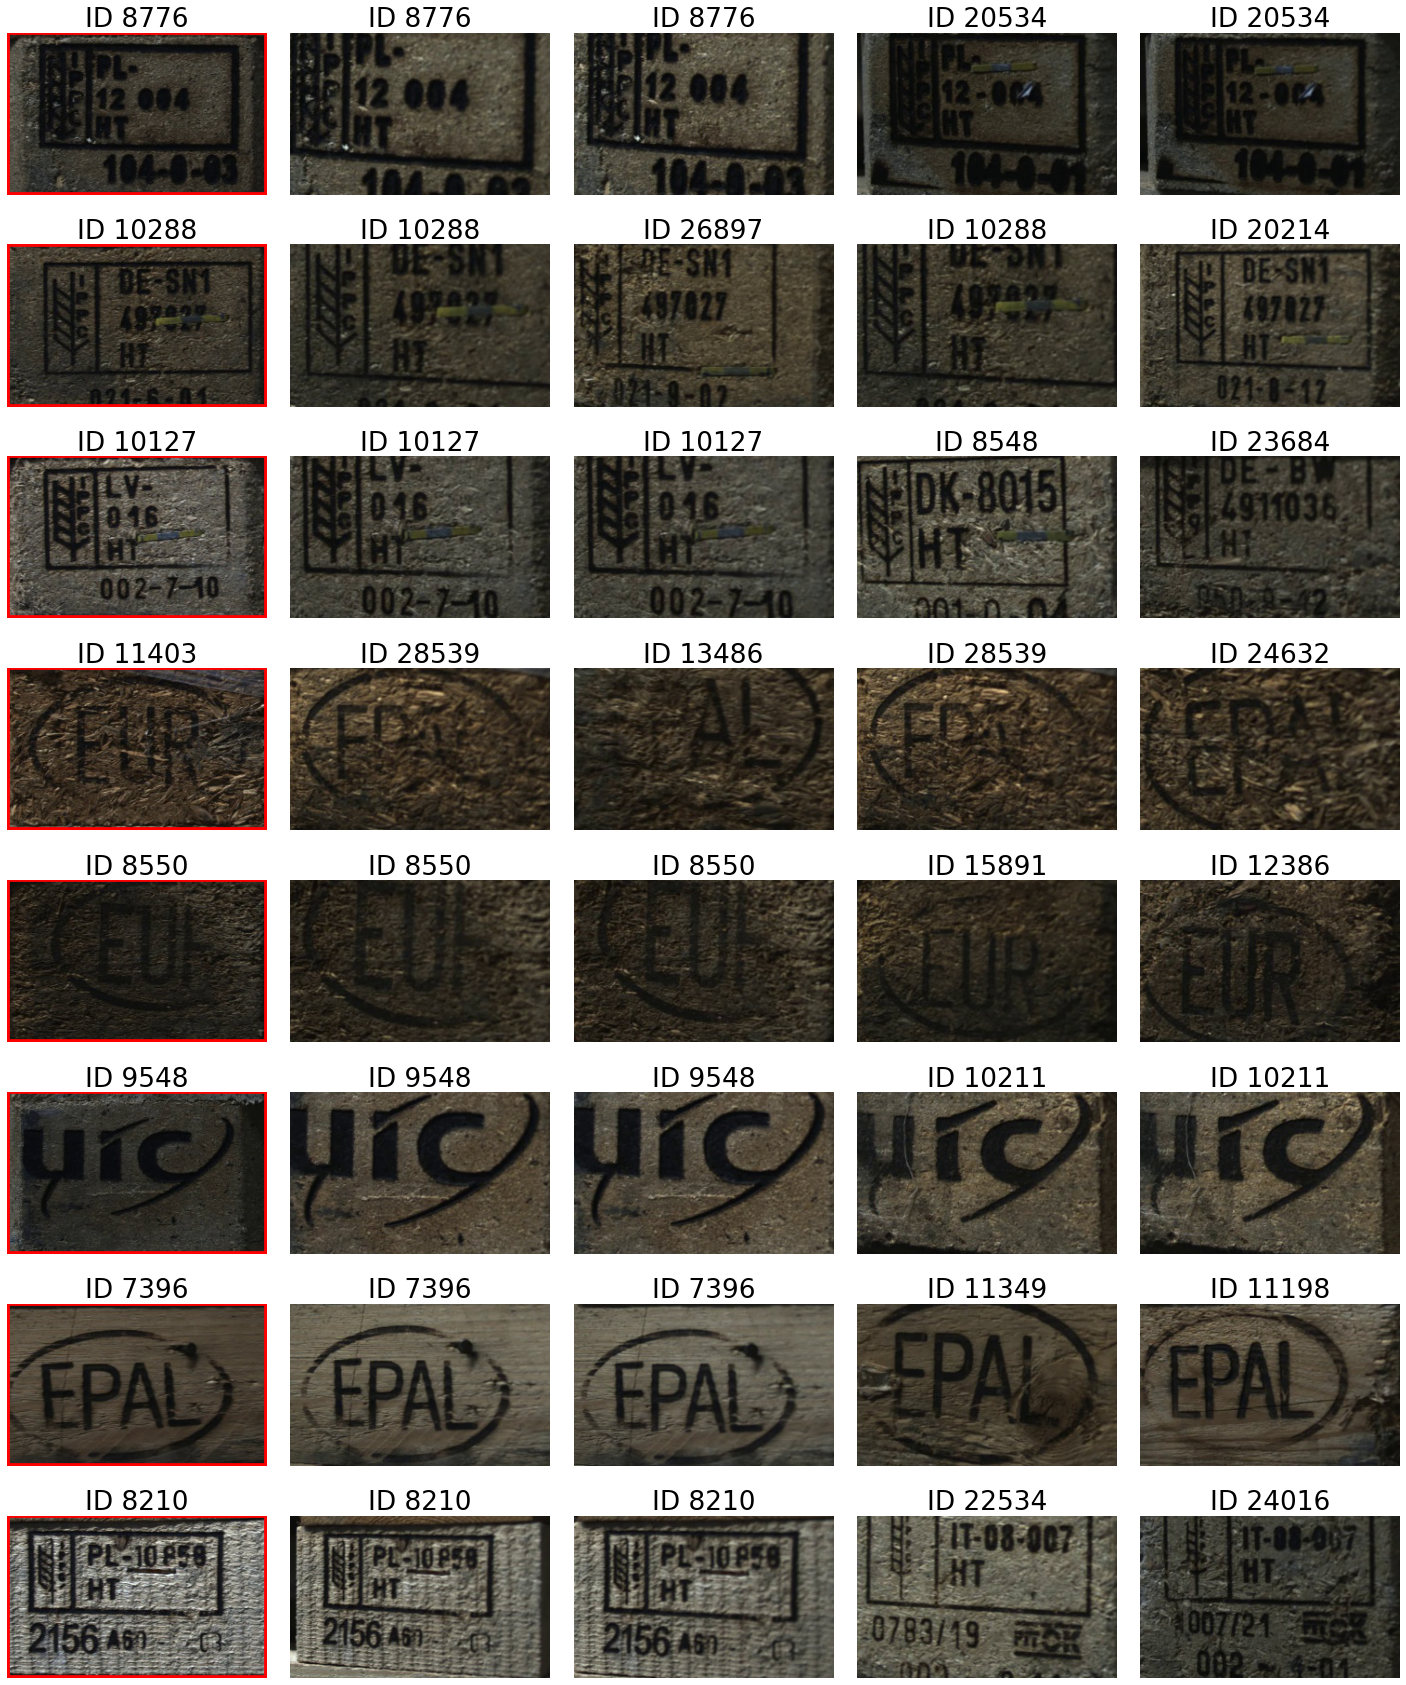

In [12]:
def plot_neighbours(n_neighbours, n_samples, seed=42, save_path=None):
    font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
    plt.rc('font', **font)

    np.random.seed(seed)
    fig, axs = plt.subplots(n_samples, n_neighbours+1)
    fig.set_figheight(n_samples*3)
    fig.set_figwidth(n_neighbours*5)
    
    if len(axs.shape) < 2:
        axs = np.expand_dims(axs, axis=0)
    query_idxs = np.random.randint(0, len(df_query), n_samples)
    for s, q_idx in enumerate(query_idxs):
        nbrs = NearestNeighbors(n_neighbors=4, algorithm="brute", metric="euclidean").fit(embeddings[df_gallery.index])
        distances, indices = nbrs.kneighbors(embeddings[np.array([df_query.iloc[q_idx].name])])

        img, lbl = vis_dataset[df_query.iloc[q_idx].name]
        img = np.array(img)
        img[:3,:,:] = np.array([255,0,0])
        img[-3:,:,:] = np.array([255,0,0])
        img[:,:3,:] = np.array([255,0,0])
        img[:,-3:,:] = np.array([255,0,0])
        ax = axs[s,0]
        ax.imshow(img)
        ax.axis("off")
        ax.set_title("ID %i" %(lbl.item()))

        for n in range(n_neighbours):
            ax = axs[s,n+1]
            img, lbl = vis_dataset[df_gallery.iloc[indices[0][n]].name]
            ax.imshow(img)
            ax.axis("off")
            ax.set_title("ID %i" %(lbl.item()))
    plt.tight_layout()
    if save_path != None:
        plt.savefig(save_path)

SEED = 20
SAMPLE_COUNT = 8
plot_neighbours(4, SAMPLE_COUNT, seed=SEED, save_path="./img/emb_vis/triplet_seed_%i_samples_%i.pdf" %(SEED, SAMPLE_COUNT))

In [134]:
classification_net = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=False)
classification_net.fc = ClassifierHead(classification_net.fc.in_features, NUM_TRAIN)
classification_net.load_state_dict(torch.load("model/model_classifier_256x128_2022-09-09.pth"))
classification_net.fc = EmbeddingHead()

contrastive_net = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=False)
contrastive_net.fc = EmbeddingHead()
contrastive_net.load_state_dict(torch.load("model/model_siamese_256x128_2022-09-10.pth"))

triplet_net = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=False)
triplet_net.fc = EmbeddingHead()
triplet_net.load_state_dict(torch.load("model/model_triplet_256x128_2022-09-10.pth"))

Using cache found in /home/nils/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/nils/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/nils/.cache/torch/hub/pytorch_vision_v0.10.0


<All keys matched successfully>

In [35]:
models = [
    ("classification", classification_net),
    ("contrastive", contrastive_net),
    ("triplet", triplet_net),
]

In [36]:
cmc = {}

for model_name, net in models:
    accs = []
    print(model_name)

    embeddings = np.zeros((len(dataset), 2048))
    net.eval()
    net.to(device)
    print(embeddings.shape)

    count = 0
    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            imgs, _ = data
            emb = net(imgs.to(device))
            embeddings[count:count+len(imgs)] = emb.detach().cpu()
            count += len(imgs)

    for k in range(1, 16):
        correct = np.zeros(len(df_query))
        nbrs = NearestNeighbors(n_neighbors=k, algorithm="brute", metric="euclidean").fit(embeddings[df_gallery.index])
        distances, indices = nbrs.kneighbors(embeddings[np.array(df_query.index)])
        
        for i in range(0, len(df_query)):
            if df_query.iloc[i].target in [df_gallery.iloc[x].target for x in indices[i]]:
                correct[i] = 1

        acc = np.sum(correct) / len(df_query)
        accs.append(acc)
        print(k, acc)
    cmc[model_name] = accs

classification
(131860, 2048)
1 0.8245
2 0.8705
3 0.9226
4 0.9364
5 0.9491
6 0.9558
7 0.9617
8 0.9651
9 0.9684
10 0.9697
11 0.9712
12 0.9732
13 0.9745
14 0.9756
15 0.9765
contrastive
(131860, 2048)
1 0.0547
2 0.0659
3 0.0795
4 0.087
5 0.0948
6 0.101
7 0.1073
8 0.1123
9 0.1168
10 0.122
11 0.1271
12 0.1313
13 0.1353
14 0.1388
15 0.1432
triplet
(131860, 2048)
1 0.8585
2 0.9141
3 0.9655
4 0.9734
5 0.9816
6 0.9844
7 0.9878
8 0.9892
9 0.9905
10 0.9921
11 0.9926
12 0.9928
13 0.9936
14 0.9941
15 0.9944


([<matplotlib.axis.XTick at 0x7f35c7388b80>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

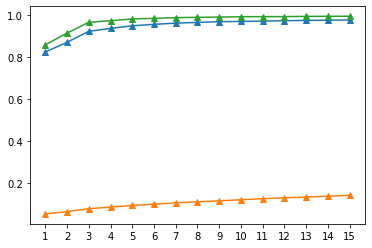

In [42]:
plt.figure()
xx = list(range(1, 16))
plt.plot(xx, cmc["classification"], marker="^")
plt.plot(xx, cmc["contrastive"], marker="^")
plt.plot(xx, cmc["triplet"], marker="^")
plt.xticks(xx)

## Novelty

In [29]:
query_selector = (df["target"] >= NUM_TRAIN) & (df["target"] < NUM_TRAIN + 5000) & (df["camera"] == 1)
df_query = df.loc[query_selector]

gallery_selector = (df["target"] >= NUM_TRAIN + 2500) & (df["camera"] == 2)
df_gallery = df.loc[gallery_selector]

print(df_query.shape)
print(df_gallery.shape)

(10000, 6)
(47744, 6)


In [30]:
labels = np.ones(len(df_query))
labels[:5000] = 0

In [32]:
cmc_novelty = {}

for model_name, net in models:
    accs = []
    print(model_name)

    embeddings = np.zeros((len(dataset), 2048))
    net.eval()
    net.to(device)
    print(embeddings.shape)

    count = 0
    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            imgs, _ = data
            emb = net(imgs.to(device))
            embeddings[count:count+len(imgs)] = emb.detach().cpu()
            count += len(imgs)

    for k in range(1, 16):
        nbrs = NearestNeighbors(n_neighbors=max(k, 3), algorithm="brute", metric="euclidean").fit(embeddings[df_gallery.index])
        distances, indices = nbrs.kneighbors(embeddings[np.array(df_query.index)])
        stds = np.std(distances[:, :3], axis=1)

        dist_outlier = np.mean(np.mean(distances[labels == 0, :1], axis=1))
        dist_inlier = np.mean(np.mean(distances[labels == 1, :1], axis=1))

        print("Dist outlier: ", dist_outlier)
        print("Dist inlier: ", dist_inlier)

        std_outlier = np.mean(stds[labels == 0])
        std_inlier = np.mean(stds[labels == 1])

        print("std outlier: ", std_outlier)
        print("std inlier: ", std_inlier)

        tau = dist_inlier + (dist_outlier - dist_inlier) / 2
        sigma = std_inlier + (std_outlier - std_inlier) / 2

        correct = np.zeros(len(df_query))
        n = 10000

        for i in range(0, n):
            if (stds[i] >= sigma or np.min(distances[i]) < tau) and labels[i] == 1 and df_query.iloc[i].target in [df_gallery.iloc[x].target for x in indices[i][:k]]: 
                correct[i] = 1
            elif (stds[i] < sigma or np.min(distances[i]) >= tau) and labels[i] == 0:
                correct[i] = 1

        acc = np.sum(correct) / n
        print(acc)
        print("tau: ", tau)
        print("sigma: ", sigma)
        accs.append(acc)
    cmc_novelty[model_name] = accs

classification
(131860, 2048)
Dist outlier:  0.4715992870426806
Dist inlier:  0.31689244037694425
std outlier:  0.020783328347134557
std inlier:  0.06620644227590829
0.8398
tau:  0.3942458637098124
sigma:  0.043494885311521424
Dist outlier:  0.4715992870426806
Dist inlier:  0.31689244037694425
std outlier:  0.020783328347134557
std inlier:  0.06620644227590829
0.8539
tau:  0.3942458637098124
sigma:  0.043494885311521424
Dist outlier:  0.4715992870426806
Dist inlier:  0.31689244037694425
std outlier:  0.020783328347134557
std inlier:  0.06620644227590829
0.8706
tau:  0.3942458637098124
sigma:  0.043494885311521424
Dist outlier:  0.4715992870426806
Dist inlier:  0.31689244037694425
std outlier:  0.020783328347134557
std inlier:  0.06620644227590829
0.8732
tau:  0.3942458637098124
sigma:  0.043494885311521424
Dist outlier:  0.4715992870426806
Dist inlier:  0.31689244037694425
std outlier:  0.020783328347134557
std inlier:  0.06620644227590829
0.8763
tau:  0.3942458637098124
sigma:  0.0434

In [119]:
# old 
k = 1
tau = dist_inlier + (dist_outlier - dist_inlier) / 2
correct = np.zeros(len(df_query))

n = 5000
for i in range(5000, 10000):
    if (np.min(distances[i]) < tau) and labels[i] == 1 and df_query.iloc[i].target == df_gallery.iloc[indices[i][0]].target:
        correct[i] = 1
    elif (np.min(distances[i]) >= tau) and labels[i] == 0:
        correct[i] = 1

acc = np.sum(correct) / n
print(acc)
print("tau: ", tau)

0.7066
tau:  0.3942458637098124


## Visualization

In [74]:
font = {'family' : 'normal',
        'size'   : 20}

plt.rc('font', **font)

In [75]:
df.head()

pallet_id                                               path  \
0  1001000000000002948  /home/nils/Documents/ude/pallet/data/pblock-32...   
1  1001000000000002948  /home/nils/Documents/ude/pallet/data/pblock-32...   
2  1001000000000002948  /home/nils/Documents/ude/pallet/data/pblock-32...   
3  1001000000000002948  /home/nils/Documents/ude/pallet/data/pblock-32...   
4  1001000000000002949  /home/nils/Documents/ude/pallet/data/pblock-32...   

   camera  frame  target  frame_rel  
0       1   1009       0          0  
1       1   1012       0          1  
2       2   1007       0          0  
3       2   1010       0          1  
4       1   1234       1          0

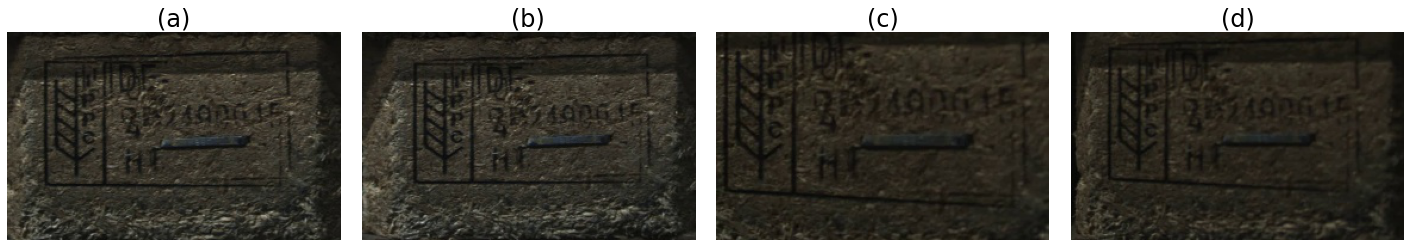

In [76]:
def plot_block(idx, save_path=None):
    rows = df.loc[df["target"] == idx]
    plt.figure(figsize=(20,5))
    titles = ["(a)", "(b)", "(c)", "(d)"]
    for i in range(len(rows)):
        row = rows.iloc[i]
        img = Image.open(row.path).convert("RGB")
        plt.subplot(141 + i)
        plt.title(titles[i])
        plt.imshow(img)
        plt.axis("off")
    plt.tight_layout()
    if save_path != None:
        plt.savefig(save_path + "%i_block_images.pdf" %(idx))


plot_block(63, save_path="img/")

In [77]:
from sklearn.manifold import TSNE

In [ ]:
embeddings_2d = TSNE(n_components=2, init="random").fit_transform(embeddings[df.iloc[:2000].index])